In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from datetime import date
from sklearn.model_selection import train_test_split

### 读取训练数据

In [3]:
off_train_df = pd.read_csv('../data/ccf_offline_stage1_train.csv')

import os

import sys

In [4]:
off_train_df.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,null,null,0,null,20160217
1,1439408,4663,11002,150:20,1,20160528,null
2,1439408,2632,8591,20:1,0,20160217,null
3,1439408,2632,1078,20:1,0,20160319,null
4,1439408,2632,8591,20:1,0,20160613,null


In [5]:
train_df = off_train_df.copy()
userbuydate = train_df[train_df['Date'] != 'null'][['User_id', 'Date']].groupby(['User_id'], as_index=False).count()
userbuydate.columns = ['User_id', 'count']
user_receive_coupon = train_df[train_df['Date_received'] != 'null'][['Date_received', 'Date']].groupby(['Date_received'],as_index=False).count()
user_receive_coupon.columns = ['Date_received', 'count']
user_buy_with_coupon = train_df[(train_df['Date'] != 'null') & (train_df['Date_received'] != 'null')][
    ['Date_received', 'Date']].groupby(['Date_received'], as_index=False).count()
user_buy_with_coupon.columns = ['Date_received', 'count']

In [6]:
merchantbuycount = train_df[(train_df['Date'] != 'null')][['Merchant_id', 'Date']].groupby(['Merchant_id'],as_index=False).count()
merchantbuycount.columns = ['Merchant_id', 'count']
have_counpon_and_use_rate = user_buy_with_coupon['count'] / user_receive_coupon['count']

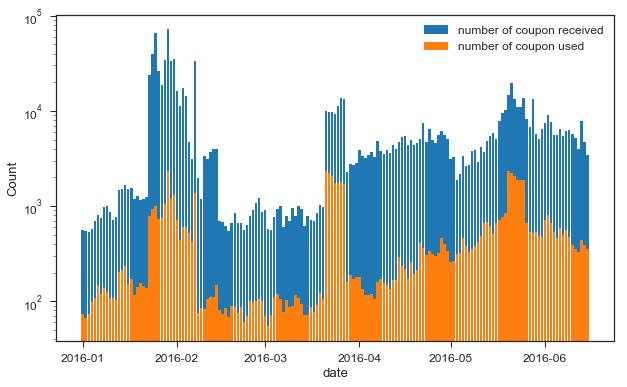

In [7]:
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.2)
plt.figure(figsize=(10, 6))
# 时间轴
date_received = train_df['Date_received'].unique()
date_received = sorted(date_received[date_received != 'null'])
date_received_dt = pd.to_datetime(date_received, format='%Y%m%d')
plt.bar(date_received_dt, user_receive_coupon['count'], label='number of coupon received')
plt.bar(date_received_dt, user_buy_with_coupon['count'], label='number of coupon used')
# 纵轴使用log的度量
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('date')
plt.legend()
plt.show()

In [8]:
# 分析优惠折扣, 提取折扣信息
def getDiscountType(row):
    if ':' in row:
        return 1
    if '.' in row:
        return 0
    return 'null'

def getDiscountExpire(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

def getDiscountAmount(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0

def getDiscountRate(row):
    if '.' in row:
        return float(row)
    if ':' in row:
        rows = row.split(':')
        rate = 1 - float(rows[1])/float(rows[0])
        return rate
    else:
        return 1.0


def addDiscountFeatures(df):
    df['discount_type'] = df['Discount_rate'].apply(getDiscountType)
    df['discount_expire'] = df['Discount_rate'].apply(getDiscountExpire)
    df['discount_amount'] = df['Discount_rate'].apply(getDiscountAmount)
    df['discount_rate'] = df['Discount_rate'].apply(getDiscountRate)
    df['distance'] = df['Distance'].replace('null',-1).astype(int)
    return df

In [9]:
# 增加工作日特征
# 获取某一天对应是星期几,1-周一 ... 7-周日
def getWeekdayInfo(row):
    if row != 'null':
        return date(int(row[0:4]),int(row[4:6]),int(row[6:8])).weekday() + 1
    else:
        return row

# 增加weekday特征,若是星期
def addWeekdayFeature(df):
    df['weekday'] = df['Date_received'].astype(str).apply(getWeekdayInfo)
    df['weekday_type'] = df['weekday'].apply(lambda x:1 if x in [6,7] else 0)

    weekday_cols = ['weekday_'+ str(i) for i in range(1,8)]

    # weekday 转化为
    wkdummy = pd.get_dummies(df['weekday'].replace('null',np.nan))
    wkdummy.columns = weekday_cols
    df[weekday_cols] = wkdummy
    return df

# 为数据集添加label, label = 1 代表领取优惠券且已消费,  label = 0代表领取优惠券但是为消费
# label = -1 代表未领取优惠券； label需反映出优惠券对消费的影响
def label(row):
    if row['Date_received'] == 'null':
        return -1
    if row['Date'] != 'null':
        #若领取优惠券且也已消费,则判断消费时间是否在领券后的15天以内
        td = pd.to_datetime(row['Date'],format='%Y%m%d') - pd.to_datetime(row['Date_received'],format='%Y%m%d')
        if td <= pd.Timedelta(15,'D'):
            return 1
    return 0

def addLabel(df):
    df['label'] = df.apply(label,axis=1)
    return df

In [10]:
train_df = addLabel(train_df)
train_df = addDiscountFeatures(train_df)
train_df = addWeekdayFeature(train_df)

In [11]:
train_df.tail(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,discount_type,discount_expire,...,distance,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7
1754864,653784,195,null,null,0,null,20160418,-1,null,0,...,0,null,0,0,0,0,0,0,0,0
1754865,653784,195,null,null,0,null,20160416,-1,null,0,...,0,null,0,0,0,0,0,0,0,0
1754866,3795296,5341,111,30:5,0,20160129,null,0,1,30,...,0,5,0,0,0,0,0,1,0,0
1754867,188086,6568,null,null,0,null,20160415,-1,null,0,...,0,null,0,0,0,0,0,0,0,0
1754868,188086,6568,null,null,0,null,20160626,-1,null,0,...,0,null,0,0,0,0,0,0,0,0
1754869,188086,6568,4723,30:1,0,20160415,null,0,1,30,...,0,5,0,0,0,0,0,1,0,0
1754870,188086,6568,null,null,0,null,20160417,-1,null,0,...,0,null,0,0,0,0,0,0,0,0
1754871,188086,6568,null,null,0,null,20160604,-1,null,0,...,0,null,0,0,0,0,0,0,0,0
1754872,212662,3532,null,null,1,null,20160308,-1,null,0,...,1,null,0,0,0,0,0,0,0,0
1754873,212662,2934,5686,30:5,2,20160321,20160330,1,1,30,...,2,1,0,1,0,0,0,0,0,0


In [12]:
# 划分数据集时  将领券时间在20160516之前没有消费的  以及消费时间在20160516之前的数据用来提取特征

In [13]:
feature = train_df[(train_df['Date'] < '20160516')|((train_df['Date'] == 'null') & (train_df['Date_received'] < '20160516'))]

In [14]:
# 领券时间在20160516 到 20160615 之间的数据作为训练/验证集

In [15]:
data = train_df[(train_df['Date_received'] > '20160516') & (train_df['Date_received'] < '20160615')]

In [16]:
from addFeature import userFeature,merchantFeature,usermerchantFeature

In [17]:
userfeature = userFeature(feature)
merchantfeature = merchantFeature(feature)
usermerchantFeature = usermerchantFeature(feature)

['User_id', 'u_coupon_count', 'u_buy_count', 'u_buy_with_coupon', 'u_merchant_count', 'u_min_distance', 'u_max_distance', 'u_mean_distance', 'u_median_distance', 'u_use_coupon_rate', 'u_buy_with_coupon_rate']
['Merchant_id', 'm_coupon_count', 'm_sale_count', 'm_sale_with_coupon', 'm_min_distance', 'm_max_distance', 'm_mean_distance', 'm_median_distance', 'm_coupon_use_rate', 'm_sale_with_coupon_rate']
['User_id', 'Merchant_id', 'um_count', 'um_buy_count', 'um_coupon_count', 'um_buy_with_coupon', 'um_buy_rate', 'um_coupon_use_rate', 'um_buy_with_coupon_rate']


In [18]:
userfeature.head()

,User_id,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate
0,1439408,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1832624,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2029232,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2223968,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73611,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
data_tv = pd.merge(data,userfeature,how='left',on='User_id')
data_tv = pd.merge(data_tv,merchantfeature,how='left',on='Merchant_id')
data_tv = pd.merge(data_tv,usermerchantFeature,how='left',on=['User_id','Merchant_id'])

In [27]:
pd.set_option('display.max_columns',None)
data_tv.head(10)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,label,discount_type,discount_expire,discount_amount,discount_rate,distance,weekday,weekday_type,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weekday_7,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate,m_coupon_count,m_sale_count,m_sale_with_coupon,m_min_distance,m_max_distance,m_mean_distance,m_median_distance,m_coupon_use_rate,m_sale_with_coupon_rate,um_count,um_buy_count,um_coupon_count,um_buy_with_coupon,um_buy_rate,um_coupon_use_rate,um_buy_with_coupon_rate
0,1439408,4663,11002,150:20,1,20160528,null,0,1,150,20,0.866667,1,6,1,0,0,0,0,0,1,0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4359.0,1296.0,45.0,0.0,10.0,2.146341,0.0,0.010323,0.034722,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1439408,2632,8591,20:1,0,20160613,null,0,1,20,1,0.950000,0,1,0,1,0,0,0,0,0,0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,18.0,3.0,1.0,1.0,1.000000,1.0,0.085714,0.166667,3.0,1.0,2.0,0.0,0.333333,0.0,0.0
2,2029232,450,1532,30:5,0,20160530,null,0,1,30,5,0.833333,0,1,0,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42939.0,8574.0,679.0,0.0,10.0,0.862229,0.0,0.015813,0.079193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2029232,6459,12737,20:1,0,20160519,null,0,1,20,1,0.950000,0,4,0,0,0,0,1,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2747744,6901,1097,50:10,null,20160606,null,0,1,50,10,0.800000,-1,1,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4705.0,9040.0,407.0,0.0,10.0,0.450128,0.0,0.086504,0.045022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,196342,1579,10698,20:1,1,20160606,null,0,1,20,1,0.950000,1,1,0,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,27.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,253750,6901,2366,30:5,0,20160518,null,0,1,30,5,0.833333,0,3,0,0,0,1,0,0,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4705.0,9040.0,407.0,0.0,10.0,0.450128,0.0,0.086504,0.045022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,343660,4663,11002,150:20,null,20160528,null,0,1,150,20,0.866667,-1,6,1,0,0,0,0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4359.0,1296.0,45.0,0.0,10.0,2.146341,0.0,0.010323,0.034722,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1113008,3621,2705,20:5,0,20160524,null,0,1,20,5,0.750000,0,2,0,0,1,0,0,0,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3347.0,3963.0,272.0,0.0,10.0,0.564854,0.0,0.081267,0.068635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1113008,2277,1495,30:10,0,20160523,null,0,1,30,10,0.666667,0,1,0,1,0,0,0,0,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,145.0,199.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
userfeature[userfeature['User_id']==2029232]

,User_id,u_coupon_count,u_buy_count,u_buy_with_coupon,u_merchant_count,u_min_distance,u_max_distance,u_mean_distance,u_median_distance,u_use_coupon_rate,u_buy_with_coupon_rate
2,2029232,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


###  领券日期在20160516到20160615之间数据划分为训练/验证集

In [35]:
train,valid = train_test_split(data_tv,stratify=data_tv['label'],random_state=100)